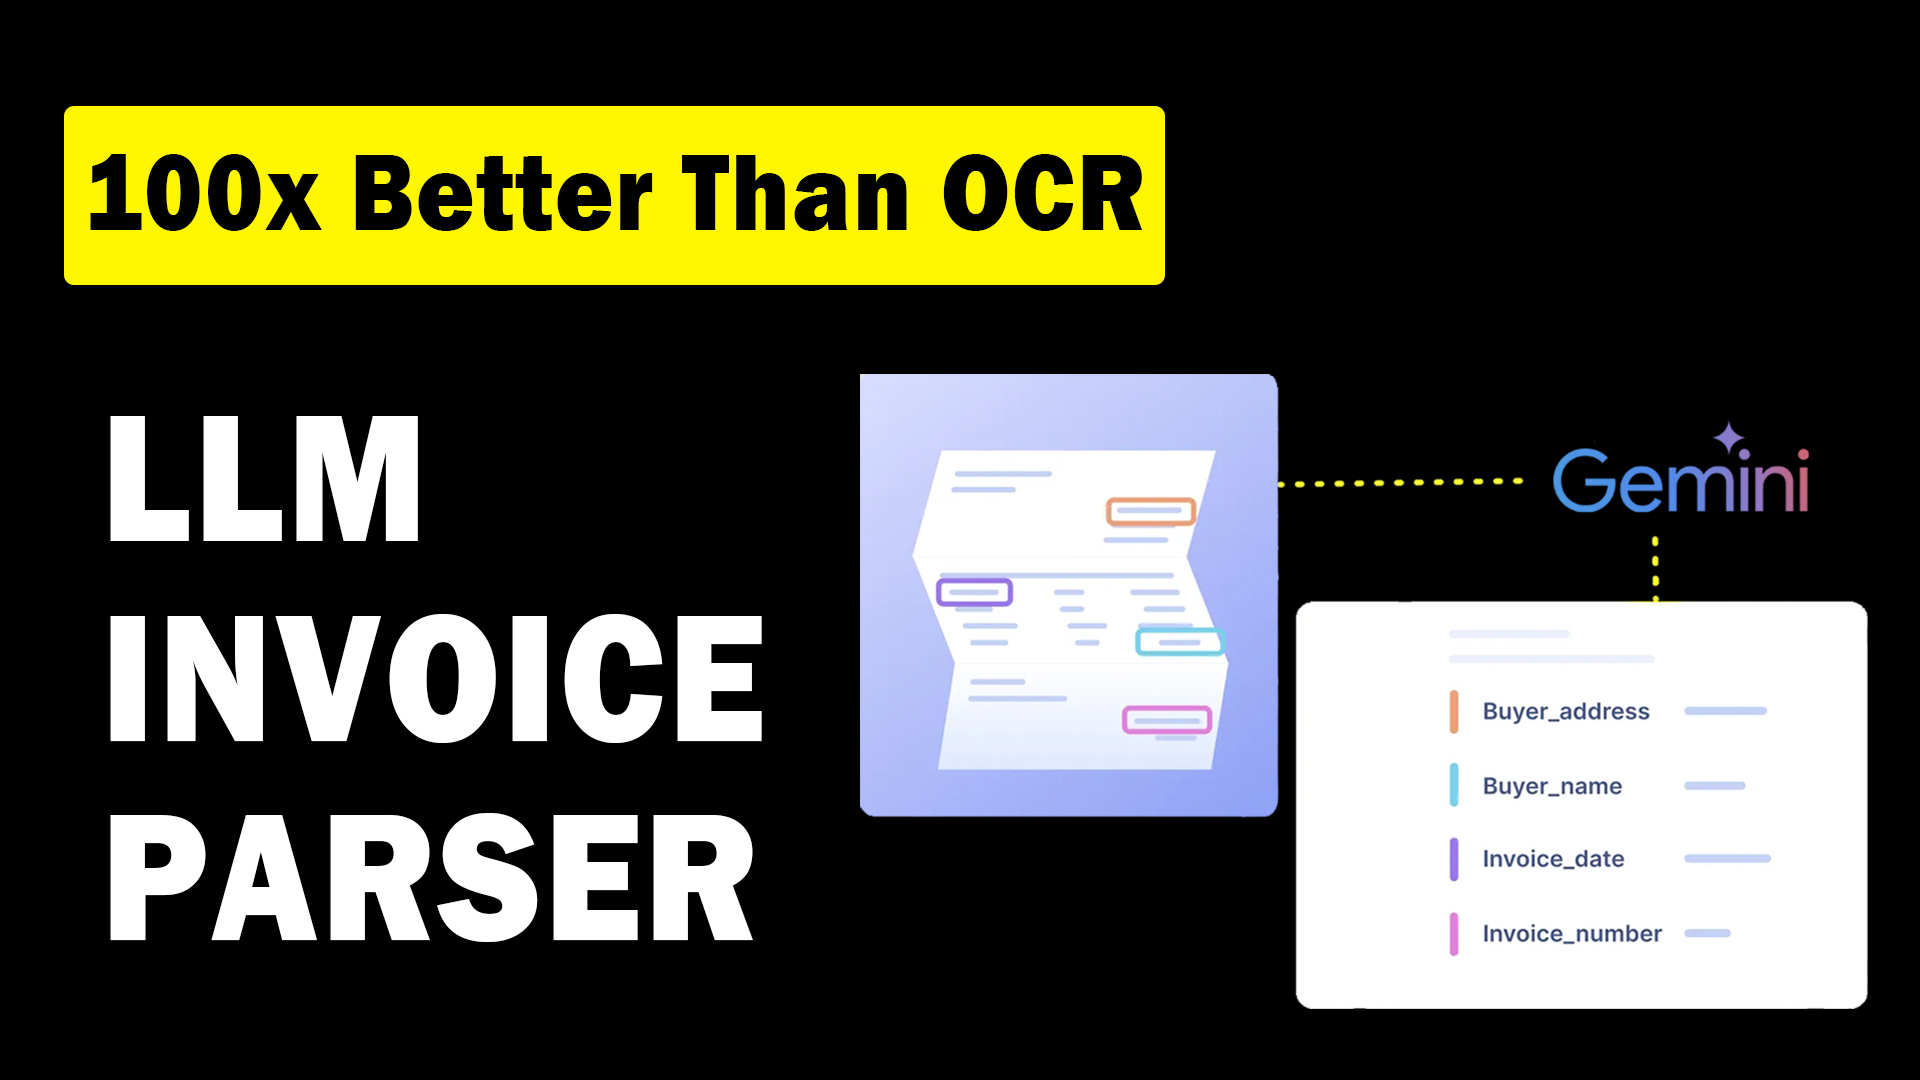

# 1. Set up Environment and create inference Client


In [ ]:
%pip install "google-genai>=1"
%pip install gradio

In [ ]:
from google import genai
from google.colab import userdata

# Create a client
api_key = userdata.get('Gemini_API_KEY')
client = genai.Client(api_key=api_key)

# Define the model you are going to use
model_id =  "gemini-2.0-flash" # or "gemini-2.0-flash-lite-preview-02-05"  , "gemini-2.0-pro-exp-02-05"

# 2. Work with PDFs and other files

Gemini models are able to process images and videos, which can used with base64 strings or using the filesapi. After uploading the file you can include the file uri in the call directly. The Python API includes a upload and delete method.


You can now upload the files using our client with the upload method. Let's try this for one of the files.

Note: The File API lets you store up to 20 GB of files per project, with a per-file maximum size of 2 GB. Files are stored for 48 hours. They can be accessed in that period with your API key, but they cannot be downloaded. File uploads are available at no cost.

In [ ]:
resume_pdf = client.files.upload(file="/content/Ahmed_Boulahia_CV.pdf", config={'display_name': 'invoice'})

In [ ]:
file_size = client.models.count_tokens(model=model_id,contents=resume_pdf)
print(f'File: {resume_pdf.display_name} equals to {file_size.total_tokens} tokens')

File: invoice equals to 1858 tokens


# 3. Structured outputs with Gemini 2.0 and Pydantic


Structured Outputs is a feature that ensures Gemini always generate responses that adhere to a predefined format, such as JSON Schema. This means you have more control over the output and how to integrate it into our application as it is guaranteed to return a valid JSON object with the schema you define.


In [ ]:
from pydantic import BaseModel, Field

# Define a Pydantic model
# Use the Field class to add a description and default value to provide more context to the model
class Topic(BaseModel):
    name: str = Field(description="The name of the topic")

class Person(BaseModel):
    first_name: str = Field(description="The first name of the person")
    last_name: str = Field(description="The last name of the person")
    email: str = Field(description="The email address of a person")
    work_experience: list[Topic] = Field(description="The work experience, if not provided please return an empty list")
    education: list[Topic] = Field(description="The education, if not provided please return an empty list")

# Define the prompt
prompt = "Ahmed Boulahia is a Tunisian AI Engineer, working on a tutorial for Invoice parsing using Google gemini models.  "

# Generate a response using the Person model
response = client.models.generate_content(model=model_id, contents=prompt, config={'response_mime_type': 'application/json', 'response_schema': Person})

# print the response as a json string
print(response.text)

{
  "education": [],
  "email": "unknown",
  "first_name": "Ahmed",
  "last_name": "Boulahia",
  "work_experience": [
    {
      "name": "AI Engineer"
    }
  ]
}


In [ ]:
# sdk automatically converts the response to the pydantic model
ahmed: Person = response.parsed

# access an attribute of the json response
print(f"{ahmed}")

first_name='Ahmed' last_name='Boulahia' email='unknown' work_experience=[Topic(name='AI Engineer')] education=[]


# 4. Extract Structured data from PDFs using Gemini 2.0


Now, let's combine the File API and structured output to extract information from our PDFs. You can create a simple method that accepts a local file path and a pydantic model and return the structured data for us. The method will:

- Upload the file to the File API
- Generate a structured response using the Gemini API
- Convert the response to the pydantic model and return it

In [ ]:
def extract_structured_data(file_path: str, model: BaseModel):
    # Upload the file to the File API
    file = client.files.upload(file=file_path, config={'display_name': file_path.split('/')[-1].split('.')[0]})
    # Generate a structured response using the Gemini API
    prompt = f"Extract the structured data from the following PDF file"
    response = client.models.generate_content(model=model_id, contents=[prompt, file], config={'response_mime_type': 'application/json', 'response_schema': model})
    # Convert the response to the pydantic model and return it
    return response.parsed

In [ ]:
from pydantic import BaseModel, Field

class Item(BaseModel):
    description: str = Field(description="The description of the item")
    quantity: float = Field(description="The Qty of the item")
    gross_worth: float = Field(description="The gross worth of the item")

class Invoice(BaseModel):
    """Extract the invoice number, date and all list items with description, quantity and gross worth and the total gross worth."""
    invoice_number: str = Field(description="The invoice number e.g. 1234567890")
    date: str = Field(description="The date of the invoice e.g. 2024-01-01")
    items: list[Item] = Field(description="The list of items with description, quantity and gross worth")
    total_gross_worth: float = Field(description="The total gross worth of the invoice")


result = extract_structured_data("/content/8_jpg.rf.4eec519654b94dc3f152d43c088c2d1f.jpg", Invoice)
print(type(result))
print(f"Extracted Invoice: {result.invoice_number} on {result.date} with total gross worth {result.total_gross_worth}")
for item in result.items:
    print(f"Item: {item.description} with quantity {item.quantity} and gross worth {item.gross_worth}")

<class '__main__.Invoice'>
Extracted Invoice: 1902185644 on 01/02/2019 with total gross worth 36.476
Item: total hors taxes with quantity 1.0 and gross worth 33.529
Item: TVA 07% with quantity 1.0 and gross worth 2.347


## Push it forward:
- Update the class invoice with the right fields
- Upgrade the system prompt
- Create a gradio App

Dataset:

https://universe.roboflow.com/

In [ ]:
# Create a client
api_key = userdata.get('Gemini_API_KEY')
client = genai.Client(api_key=api_key)

# Define the model you are going to use
model_id =  "gemini-2.0-pro-exp-02-05" # or "gemini-2.0-flash-lite-preview-02-05"  , "gemini-2.0-pro-exp-02-05"

In [ ]:
from pydantic import BaseModel, Field
from datetime import date
from typing import List, Optional

class ContactInformation(BaseModel):
    name: str = Field(description="Name of the person or business")
    address: str = Field(description="Address details")
    phone: Optional[str] = Field(default=None, description="Phone number")
    email: Optional[str] = Field(default=None, description="Email address")

class Item(BaseModel):
    description: str = Field(description="Description of the item")
    quantity: float = Field(description="Quantity of the item")
    unit_price: float = Field(description="Price per unit of the item")
    subtotal: float = Field(description="Subtotal for this item")

class Invoice_2(BaseModel):
    invoice_number: str = Field(description="Unique identifier for the invoice")
    business_info: ContactInformation = Field(description="Your business details")
    customer_info: ContactInformation = Field(description="Client details")
    items: List[Item] = Field(description="List of itemized goods or services")
    tax: float = Field(description="Applicable tax amount")
    total: float = Field(description="Total amount after tax")
    payment_methods: Optional[str] = Field(default=None, description="Payment methods (e.g., Bank details, PayPal)")

In [ ]:
result = extract_structured_data("/content/8_jpg.rf.4eec519654b94dc3f152d43c088c2d1f.jpg", Invoice_2)
print(result)

invoice_number='1902185644' business_info=ContactInformation(name='orange', address='24, rue 10048\n1009 El Ouerdia', phone=None, email=None) customer_info=ContactInformation(name='Mme FAYZA ABESSI', address='N° client: ACNT00922236', phone=None, email=None) items=[Item(description='total hors taxes', quantity=33.529, unit_price=33.529, subtotal=33.529), Item(description='TVA 07%', quantity=2.347, unit_price=2.347, subtotal=2.347)] tax=2.347 total=36.476 payment_methods=None


In [ ]:
def extract_structured_data_json(file_path: str, model: BaseModel):
    # Upload the file to the File API
    file = client.files.upload(file=file_path, config={'display_name': file_path.split('/')[-1].split('.')[0]})
    # Generate a structured response using the Gemini API
    prompt = f"Extract the structured data from the following PDF file"
    response = client.models.generate_content(model=model_id, contents=[prompt, file], config={'response_mime_type': 'application/json', 'response_schema': model})
    # Convert the response to the pydantic model and return it
    return response.text

In [ ]:
result = extract_structured_data_json("/content/8_jpg.rf.4eec519654b94dc3f152d43c088c2d1f.jpg", Invoice_2)
print(result)

{
  "business_info": {
    "address": "24, rue 10048\n1009 El Ouerdia",
    "name": "orange",
    "email": null,
    "phone": null
  },
  "customer_info": {
    "address": "24, rue 10048\n1009 El Ouerdia",
    "name": "Mme FAYZA ABESSI",
    "email": null,
    "phone": null
  },
  "invoice_number": "1902185644",
  "items": [
    {
      "description": "total hors taxes",
      "quantity": 33.529,
      "subtotal": 33.529,
      "unit_price": 33.529
    },
    {
      "description": "TVA 07%",
      "quantity": 2.347,
      "subtotal": 2.347,
      "unit_price": 2.347
    }
  ],
  "tax": 2.347,
  "total": 36.476,
  "payment_methods": null
}


In [ ]:
import gradio as gr
import json

In [ ]:
def extract_structured_data_json(file_path: str, model: BaseModel):
    # Upload the file to the File API
    file = client.files.upload(file=file_path, config={'display_name': file_path.split('/')[-1].split('.')[0]})
    # Generate a structured response using the Gemini API
    prompt = f"Extract the structured data from the following PDF file"
    response = client.models.generate_content(model=model_id, contents=[prompt, file], config={'response_mime_type': 'application/json', 'response_schema': model})
    # Convert the response to the pydantic model and return it
    return response.text

# Gradio interface with a themed layout
with gr.Blocks(theme=gr.themes.Soft(), css="body {background-color: #1e1e2f; color: white;} .container {padding: 20px;} .gr-block {overflow: visible; max-height: none;}") as app:
    gr.Markdown("## 🧾 Invoice Parser - Structured JSON Extractor", elem_id="title")

    with gr.Row():
        with gr.Column():
            file_input = gr.File(label="Upload Your Document or Image", file_types=[".pdf", ".docx", ".txt", ".png", ".jpg", ".jpeg"], interactive=True)
            file_viewer = gr.Image(label="Uploaded File Preview", elem_classes=["file-preview"])
            process_button = gr.Button("Process File")

        with gr.Column():
            output_text = gr.JSON(label="Parsed JSON Output", elem_classes=["output-area"])

    # Handle the file processing logic
    def process_file(file_obj):
        if file_obj:
            return json.loads(extract_structured_data_json(file_obj.name, Invoice_2))
        return {"error": "Please upload a file."}

    def show_uploaded_file(file_obj):
        if file_obj:
            return file_obj.name

    file_input.change(show_uploaded_file, inputs=file_input, outputs=file_viewer)
    process_button.click(process_file, inputs=file_input, outputs=output_text)

    gr.Markdown("---")
    gr.Markdown("Built By Ahmed Boulahia with ❤️ using Gradio")

app.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://be34eae1e5b41a37a5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
